In [1]:
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from lifelines.utils import concordance_index
from xgboost import XGBRegressor,XGBClassifier
from sklearn.linear_model import Lasso
from keras.models import Sequential
from keras.layers import Dense, Dropout


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from abc import ABC, abstractmethod

import shap



2024-06-26 10:23:23.780397: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 10:23:23.784884: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 10:23:23.838999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 10:23:24.586608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Functions and Classes

## Models

In [2]:
class ModelStatStorage:
    def __init__(self, aucs=[], fprs=[], tprs=[], model=[]):
        self.aucs = aucs
        self.fprs = fprs
        self.tprs = tprs
        self.model = model
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        self.y_pred = []
        self.pred_probas = []
        self.scores = []


class Model(ABC):
    # test_H_mask = X_test['id'] < 60
    # test_L_mask = X_test['id'] >= 60
    def __init__(self, model_name, param_dict):
        """
        Arguments:
        model_name - name of model
        param_dict - params to be passed to model
        """

        # 用于存储模型相关参数
        # store results of each fold of cross val
        self.cv_storage = ModelStatStorage([], [], [], [])

        # access actual self.model underneath for increased control if needed
        self.model_name = model_name
        self.model = self.init_model(model_name, param_dict)
        # self.cv_storage = CVModelStorage([], [], [], []) #store results of each fold of cross val
        # stores the index of the model with best score, within cv_storage lists
        self.argmax_ind = -1
        self.params_dict = param_dict
        self.train_splits = []
        self.SEED = 13

    @abstractmethod
    def init_model(self, model_name, param_dict):
        """ 
            Returns model initialized with param_dict parameters
        """
        pass

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def get_scores(self, X_train, y_train, X_test, y_test):
        clf = self.model
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        return train_score, test_score

    def get_H_L_score(self, X_test, y_test):
        pass

    def show_performance(self):
        results = []
        model_performance = self.cv_storage
        for record in zip([self.model_name]*len(model_performance.aucs), model_performance.aucs, model_performance.scores):
            results.append(record)
        results_df = pd.DataFrame(
            results, columns=['model', 'aucs', 'accuracy'])
        print(results_df)
        results_df = results_df.groupby(by=['model']).mean()
        print(results_df)

    def get_performance_df(self):
        results = []
        model_performance = self.cv_storage
        for record in zip([self.model_name]*len(model_performance.scores), model_performance.aucs, model_performance.scores):
            results.append(record)
        results_df = pd.DataFrame(
            results, columns=['model', 'auc', 'accuracy'])
        return results_df

    def run_k_fold(self, X, y, n_splits=5,is_multiclass=False):
        '''
         Input X is a 2d list, y is a list.
        '''
        skf = StratifiedKFold(
            n_splits=n_splits, shuffle=True, random_state=self.SEED)
        for train, test in skf.split(X, y):
            X_train = X.iloc[train, :]
            y_train = y.iloc[train,:]
            X_test = X.iloc[test, :]
            y_test = y.iloc[test,:]
            self.train_model(X_train, y_train)

            if hasattr(self.model, 'predict_proba'):
                pred_proba = self.model.predict_proba(X_test)
            else:
                print("Multiclass currently do not supports predict_proba")
                pred_proba = None
            if is_multiclass:
                # make a one hot multiclass label
                y_one_hot = np.zeros(pred_proba.shape)
                for idx, label in enumerate(y_test):
                    y_one_hot[idx, label] = 1
                fpr, tpr, _ = roc_curve(y_one_hot.ravel(), pred_proba.ravel())
            else:
                fpr, tpr, _ = roc_curve(y_test, pred_proba[::,1])
            a = auc(fpr, tpr)
            self.cv_storage.pred_probas.append(pred_proba)
            self.cv_storage.aucs.append(a)
            self.cv_storage.fprs.append(fpr)
            self.cv_storage.tprs.append(tpr)
            # self.cv_storage.model.append(pickle.dumps(self.model))
            self.cv_storage.X_train.append(X_train)
            self.cv_storage.y_train.append(y_train)
            self.cv_storage.X_test.append(X_test)
            self.cv_storage.y_test.append(y_test)
            self.cv_storage.scores.append(self.model.score(X_test, y_test))


# XGB
class XGB(Model):
    def init_model(self, model_name, param_dict):
        param_dict = dict({'eval_metric': 'mlogloss'}, **param_dict)
        clf = XGBClassifier(**param_dict)
        return clf

# Lasso
class Lasso_Model(Model):
    def init_model(self, model_name, param_dict):
        param_dict = dict(
            {'penalty': 'l1', 'solver': 'liblinear'}, **param_dict)
        clf = LogisticRegression(**param_dict)
        # clf=Lasso(**param_dict)
        return clf

    def train_model(self, X_train, y_train):
        super().train_model(X_train, y_train)

# SVM
class SVM_Model(Model):
    def init_model(self, model_name, param_dict):
        param_dict = dict({'decision_function_shape': 'ovo',
                          'probability': True}, **param_dict)
        clf = SVC(**param_dict)
        return clf

    def train_model(self, X_train, y_train):
        # 欠拟合时不要加入正则项
        # X_train=normalize(X_train,norm='l1')
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        super().train_model(X_train, y_train)


## Functions

### Shap Selection

In [3]:
def get_important_feature_indexes(mean_shap, feature_num=10, select_method=2):
    '''
    0-负相关，1-正相关，2-绝对值
    '''
    if select_method == 2:
        mean_shap = np.absolute(mean_shap)
    mean_shap_sort = mean_shap.argsort()
    # 选择倒数n个
    if select_method == 2:
        feature_num = -feature_num
        feature_indexes = mean_shap_sort[feature_num:]
    if select_method == 1:
        feature_num = -feature_num
        feature_indexes = mean_shap_sort[feature_num:]

    if select_method == 0:
        feature_indexes = mean_shap_sort[:feature_num]

    feature_indexes = list(feature_indexes)
    return feature_indexes

In [4]:

def get_fold_mean_shap_value(clf_model):
    fold_num = len(clf_model.cv_storage.X_train)
    fold_mean_shap_value = []
    for i in range(fold_num):
        # clf = pickle.loads(clf_model.cv_storage.model[i])
        X_train = clf_model.cv_storage.X_train[i]
        X_test = clf_model.cv_storage.X_test[i]
        # define explainer
        explainer = shap.Explainer(clf_model.model)
        shap_values = explainer.shap_values(X_test)
        # special process for multi-class
        shap_values=np.array(shap_values)
        if(len(shap_values.shape)>2):
            shap_values=np.mean(shap_values, axis=0)
        shap_values = np.mean(shap_values, axis=0)
        fold_mean_shap_value.append(shap_values)
    # process on mean shap
    fold_mean_shap_value = np.mean(np.array(fold_mean_shap_value), axis=0)
    return fold_mean_shap_value


In [5]:

def get_important_feature_by_shap(X,y, feature_num=10):
    '''
        input X,y, feature_num
    '''
    # pre train
    clf_model=XGB('XGB',{})
    clf_model.run_k_fold(X,y)
    # get mean shap value by different folds
    fold_mean_shap_value = get_fold_mean_shap_value(clf_model)
    # get indexes of features
    feature_indexes = get_important_feature_indexes(
        fold_mean_shap_value, feature_num=feature_num)
    # get names of features
    cols = X.columns
    features = cols[feature_indexes]
    features=features[::-1]
    return features

# Classification

## Old Version Test

## Label Process

In [6]:
sample_df=pd.read_csv('../data/Using/sample.csv')
sample_df.shape

(164, 25)

In [7]:
def get_survival_level(sample,low=12,high=48):
    if sample.oss==0:
        if sample.os<low:
            return None
        else:
            if sample.os>=high:
                return 'high'
            else:
                return None
    if sample.oss==1:
        if sample.os>=high:
            return 'high'
        if sample.os<low:
            return 'low'
        if (sample.os>=low)&(sample.os<high):
            return None

In [8]:
sample_df[sample_df['oss']==0]['os']

3       86.430000
4       58.730000
5       61.970000
7      117.830000
8      125.630000
          ...    
155     53.900000
158     52.700000
159      1.100000
160     48.733333
162     26.966667
Name: os, Length: 80, dtype: float64

In [9]:
for low in [12,24,36,48]:
    for high in [24,36,48]:
        if low>high:
            continue
        survival_level=[get_survival_level(sample,low,high) for index,sample in sample_df.iterrows()]
        sample_df['survival_level']=survival_level
        print(f"low={low},high={high},{sample_df['survival_level'].value_counts()}")
        print(sample_df[~sample_df['survival_level'].isna()]['oss'].value_counts())
        print()

low=12,high=24,survival_level
high    99
low     27
Name: count, dtype: int64
oss
1.0    64
0.0    62
Name: count, dtype: int64

low=12,high=36,survival_level
high    69
low     27
Name: count, dtype: int64
oss
0.0    50
1.0    46
Name: count, dtype: int64

low=12,high=48,survival_level
high    57
low     27
Name: count, dtype: int64
oss
0.0    43
1.0    41
Name: count, dtype: int64

low=24,high=24,survival_level
high    99
low     47
Name: count, dtype: int64
oss
1.0    84
0.0    62
Name: count, dtype: int64

low=24,high=36,survival_level
high    69
low     47
Name: count, dtype: int64
oss
1.0    66
0.0    50
Name: count, dtype: int64

low=24,high=48,survival_level
high    57
low     47
Name: count, dtype: int64
oss
1.0    61
0.0    43
Name: count, dtype: int64

low=36,high=36,survival_level
high    69
low     65
Name: count, dtype: int64
oss
1.0    84
0.0    50
Name: count, dtype: int64

low=36,high=48,survival_level
low     65
high    57
Name: count, dtype: int64
oss
1.0    79
0.0  

## Prepare Data

In [10]:
metab_df=pd.read_csv('../../Subtype/data/Using/metab.csv',index_col=0)
sample_df=pd.read_csv('../../Subtype/data/Using/sample.csv',index_col=0)

low=36
high=36
survival_level=[get_survival_level(sample,low,high) for index,sample in sample_df.iterrows()]
sample_df['survival_level']=survival_level

metab_num=metab_df.shape[1]
metab_survival_df=pd.merge(metab_df,sample_df.loc[:,['survival_level']],left_index=True,right_index=True)
metab_survival_df
metab_survival_df=metab_survival_df[~metab_survival_df['survival_level'].isna()]

print(metab_df.shape)

(103, 171)


In [40]:
X = metab_survival_df.iloc[:,:metab_num]
y = metab_survival_df.loc[:,['survival_level']]

# Encode Y
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




# Encode labels

# Impute missing values and standardize the features
# imputer = SimpleImputer(strategy='mean')
# scaler = StandardScaler()

# X_train = imputer.fit_transform(X_train)
# X_test = imputer.transform(X_test)

X.describe()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,2-aminooctanoic acid,2-deoxyglucose-6-phosphate,2-hydroxy-2-methylbutanedioic acid,2-hydroxygluterate,2-isopropylmalic acid,2-ketohexanoic acid,2-keto-isovalerate,3-phosphoglycerate,4-aminobutyrate,4-phosphopantothenate,...,udp-n-acetyl-glucosamine,ump,urea,uric acid,uridine,utp,valine,xanthine,xanthosine,xanthurenic acid
count,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,...,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01
mean,2.407713e-16,-4.307130e-16,-3.317293e-16,-3.825588e-16,-1.819161e-16,4.280378e-17,-5.243463e-16,-2.541474e-17,1.123599e-16,3.758707e-16,...,4.949187e-16,-4.912193e-16,6.219924e-16,-1.096847e-16,1.872665e-17,-6.286805e-17,-3.424302e-16,-7.758185e-17,-2.554851e-16,-4.547902e-17
std,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,...,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00
min,-1.499393e+00,-1.432611e+00,-1.282751e+00,-1.540339e+00,-1.652768e+00,-1.156503e+00,-1.395606e+00,-1.564742e+00,-7.905436e-01,-1.257023e+00,...,-1.904205e+00,-1.771910e+00,-2.056227e+00,-1.217189e+00,-1.844176e+00,-8.302237e-01,-1.330279e+00,-1.187827e+00,-9.998017e-01,-1.411144e+00
25%,-6.726751e-01,-6.441893e-01,-7.338625e-01,-6.634157e-01,-7.450383e-01,-6.634268e-01,-6.457684e-01,-5.895540e-01,-5.716389e-01,-6.849663e-01,...,-6.499676e-01,-6.177730e-01,-6.503948e-01,-6.216613e-01,-6.414679e-01,-5.869645e-01,-8.593007e-01,-8.055853e-01,-7.000396e-01,-7.072013e-01
50%,-1.174894e-01,-3.065710e-01,-2.890123e-01,-2.842647e-01,-1.252821e-01,-3.502106e-01,-1.782116e-01,-1.982323e-01,-3.992063e-01,-2.556043e-01,...,-1.571506e-01,-1.335076e-01,-2.227571e-01,-2.150107e-01,-1.541983e-01,-2.732682e-01,-1.936241e-01,-3.394827e-01,-3.402634e-01,-2.233422e-01
75%,2.196836e-01,3.164177e-01,4.477009e-01,4.898779e-01,5.305423e-01,3.658083e-01,3.866153e-01,2.549208e-01,1.691716e-01,4.656059e-01,...,5.687583e-01,5.893972e-01,5.343217e-01,1.171614e-01,5.785358e-01,1.282921e-01,5.542326e-01,8.204624e-01,2.906190e-01,2.595146e-01
max,5.051540e+00,3.142541e+00,3.746512e+00,4.208382e+00,3.750086e+00,3.357828e+00,5.232996e+00,3.725547e+00,5.273005e+00,3.337487e+00,...,2.687720e+00,4.008192e+00,3.639602e+00,3.657531e+00,2.606583e+00,5.506387e+00,2.818476e+00,2.554770e+00,4.173178e+00,3.941078e+00


## Model Building

In [41]:
sig_features={}
sig_features['shap']=get_important_feature_by_shap(X,y,20)

[10:30:44] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:30:44] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:30:44] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:30:44] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:30:44] WARNING: /croot/x

In [42]:
sig_features['shap']

Index(['quinolinate', 'creatinine', 'uridine', 'glycolate', 'tyrosine',
       'nad+_neg', 'uric acid', 'cholesterol sulfate', 'betaine aldehyde',
       'phenylalanine', 'cdp-choline', 'dtmp_pos',
       'aminoimidazole carboxamide ribonucleotide', 'pantothenate',
       'hydroxyphenylpyruvate', 'cytosine', '4-phosphopantothenate',
       'glucose-1-phosphate', 'asparagine', 'itaconic acid'],
      dtype='object')

### Second Split

In [44]:
selected_features=sig_features['shap']
X = metab_survival_df.loc[:,selected_features]
y = metab_survival_df.loc[:,['survival_level']]
label_encoder = LabelEncoder()
y['survival_level'] = label_encoder.fit_transform(y)

# Scaler on X
scaler = StandardScaler()
X_array=scaler.fit_transform(X)
X=pd.DataFrame(X_array,index=X.index,columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Encode labels

# Impute missing values and standardize the features
# imputer = SimpleImputer(strategy='mean')
# scaler = StandardScaler()

# X_train = imputer.fit_transform(X_train)
# X_test = imputer.transform(X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Old Model Test

In [49]:
clf_model=SVM_Model('SVM',{})
clf_model.run_k_fold(X,y)
clf_model.get_performance_df()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was f

,model,auc,accuracy
0,SVM,0.680556,0.705882
1,SVM,0.680556,0.647059
2,SVM,0.743056,0.647059
3,SVM,0.765625,0.625000
4,SVM,0.562500,0.500000


In [50]:
X_train.shape

(58, 20)

In [51]:
y_train['survival_level'].values

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Lasso (Logistic Regression with L1 penalty)
lasso_model = LogisticRegression(penalty='l1',C=1, solver='liblinear')
lasso_model.fit(X_train, y_train['survival_level'].values)
# XGBoost Model
# xgb_model = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='logloss',
#     max_depth=3,
#     min_child_weight=5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0.1,
#     reg_lambda=1.0,
#     learning_rate=0.01,
#     n_estimators=1000
# )
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss'
)
# xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
xgb_model.fit(X_train,y_train['survival_level'].values)


# SVM Model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train['survival_level'].values)

SVC(kernel='linear', probability=True)

- Why does it take so long for svm-model when C is set to 10 and X_train shape is (50,20)

In [54]:
# lasso_model = LogisticRegression(penalty='l1', solver='liblinear')
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
# grid_search = GridSearchCV(lasso_model, param_grid, cv=5)
# grid_search.fit(X_test, y_test)
# best_lasso_model = grid_search.best_estimator_

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [58]:
# Predictions
lasso_predictions = lasso_model.predict(X_train)
xgb_predictions = xgb_model.predict(X_train)
svm_predictions = svm_model.predict(X_train)

# Evaluation
print("Lasso Model:")
print("Accuracy:", accuracy_score(y_train, lasso_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_train, lasso_predictions))
print("Classification Report:\n", classification_report(y_train, lasso_predictions))

print("XGBoost Model:")
print("Accuracy:", accuracy_score(y_train, xgb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_train, xgb_predictions))
print("Classification Report:\n", classification_report(y_train, xgb_predictions))

print("SVM Model:")
print("Accuracy:", accuracy_score(y_train, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_train, svm_predictions))
print("Classification Report:\n", classification_report(y_train, svm_predictions))


Lasso Model:
Accuracy: 0.8275862068965517
Confusion Matrix:
 [[24  6]
 [ 4 24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.80      0.86      0.83        28

    accuracy                           0.83        58
   macro avg       0.83      0.83      0.83        58
weighted avg       0.83      0.83      0.83        58

XGBoost Model:
Accuracy: 1.0
Confusion Matrix:
 [[30  0]
 [ 0 28]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        28

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58

SVM Model:
Accuracy: 0.8793103448275862
Confusion Matrix:
 [[26  4]
 [ 3 25]]
Classification Report:
               precision    recall  f1-score   sup

In [59]:
# Predictions
lasso_predictions = lasso_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

# Evaluation
print("Lasso Model:")
print("Accuracy:", accuracy_score(y_test, lasso_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lasso_predictions))
print("Classification Report:\n", classification_report(y_test, lasso_predictions))

print("XGBoost Model:")
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_predictions))
print("Classification Report:\n", classification_report(y_test, xgb_predictions))

print("SVM Model:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))
print("Classification Report:\n", classification_report(y_test, svm_predictions))


Lasso Model:
Accuracy: 0.8
Confusion Matrix:
 [[10  3]
 [ 2 10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.77      0.83      0.80        12

    accuracy                           0.80        25
   macro avg       0.80      0.80      0.80        25
weighted avg       0.80      0.80      0.80        25

XGBoost Model:
Accuracy: 0.6
Confusion Matrix:
 [[6 7]
 [3 9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.46      0.55        13
           1       0.56      0.75      0.64        12

    accuracy                           0.60        25
   macro avg       0.61      0.61      0.59        25
weighted avg       0.62      0.60      0.59        25

SVM Model:
Accuracy: 0.64
Confusion Matrix:
 [[8 5]
 [4 8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.

In [101]:
print(y_test)
print(xgb_predictions)
print(lasso_predictions)

[0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0]
[1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0]
[1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0]


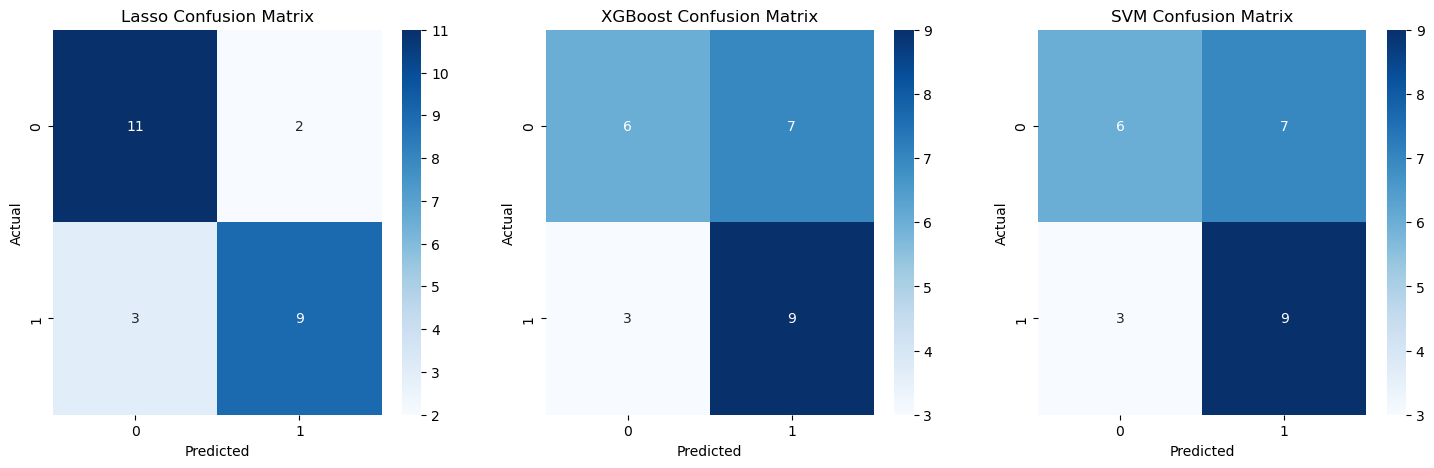

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Bar plot of accuracy
# models = ['Lasso', 'XGBoost', 'SVM']
# accuracies = [
#     accuracy_score(y_test, lasso_predictions),
#     accuracy_score(y_test, xgb_predictions),
#     accuracy_score(y_test, svm_predictions)
# ]

# plt.figure(figsize=(10, 6))
# sns.barplot(x=models, y=accuracies)
# plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.title('Comparison of Model Performance')
# plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

conf_matrices = [
    confusion_matrix(y_test, lasso_predictions),
    confusion_matrix(y_test, xgb_predictions),
    confusion_matrix(y_test, svm_predictions)
]
titles = ['Lasso', 'XGBoost', 'SVM']

for ax, cm, title in zip(axes, conf_matrices, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.show()


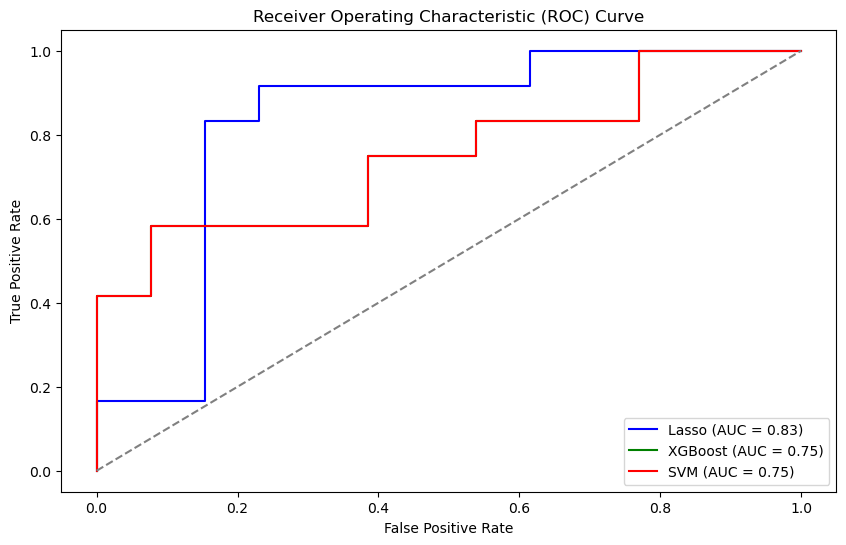

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area for each model
lasso_prob = lasso_model.predict_proba(X_test)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
svm_prob = svm_model.predict_proba(X_test)[:, 1]

lasso_fpr, lasso_tpr, _ = roc_curve(y_test, lasso_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

lasso_auc = roc_auc_score(y_test, lasso_prob)
xgb_auc = roc_auc_score(y_test, xgb_prob)
svm_auc = roc_auc_score(y_test, svm_prob)

plt.figure(figsize=(10, 6))
plt.plot(lasso_fpr, lasso_tpr, color='blue', label=f'Lasso (AUC = {lasso_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, color='green', label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, color='red', label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## 5-fold

/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-v

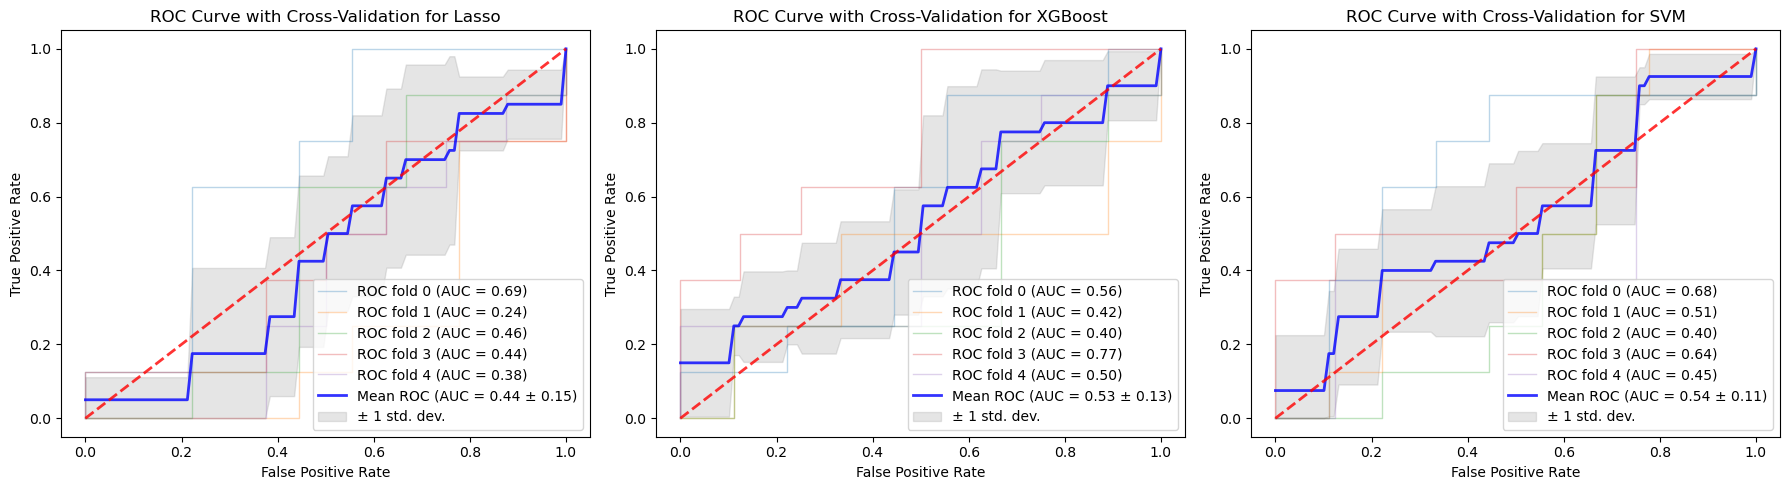

In [112]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score

# Prepare cross-validation
cv = StratifiedKFold(n_splits=5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Function to plot ROC curves
def plot_cv_roc_curve(classifier, X, y, label, ax):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, _ = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label='± 1 std. dev.')

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve with Cross-Validation for {label}')
    ax.legend(loc='lower right')

# Plot ROC curves for each classifier in subplots
plot_cv_roc_curve(lasso_model, X, y, 'Lasso', axes[0])
plot_cv_roc_curve(xgb_model, X, y, 'XGBoost', axes[1])
plot_cv_roc_curve(svm_model, X, y, 'SVM', axes[2])

plt.tight_layout()
plt.show()



# Regression

## Prepare Data

### Generate Test Data

In [6]:

# Generate synthetic dataset
np.random.seed(42)
data_size = 1000
data = {
    'age': np.random.randint(20, 80, data_size),
    'tumor_size': np.random.normal(30, 10, data_size),
    'tumor_stage': np.random.randint(1, 4, data_size),
    'os': np.random.randint(1, 60, data_size)
}
df = pd.DataFrame(data)
df['oss'] = np.random.randint(0, 2, data_size)  # 1 if the oss (death) occurred, 0 if censored

# Split the dataset
X = df[['age', 'tumor_size', 'tumor_stage']]
y = df[['os', 'oss']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute missing values and standardize the features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Read Metab Data

In [7]:
metab_df=pd.read_csv('../../Subtype/data/Using/metab.csv',index_col=0)
sample_df=pd.read_csv('../../Subtype/data/Using/sample.csv',index_col=0)


In [8]:
metab_num=metab_df.shape[1]
metab_survival_df=pd.merge(metab_df,sample_df.loc[:,['os','oss']],left_index=True,right_index=True)
metab_survival_df

,2-aminooctanoic acid,2-deoxyglucose-6-phosphate,2-hydroxy-2-methylbutanedioic acid,2-hydroxygluterate,2-isopropylmalic acid,2-ketohexanoic acid,2-keto-isovalerate,3-phosphoglycerate,4-aminobutyrate,4-phosphopantothenate,...,urea,uric acid,uridine,utp,valine,xanthine,xanthosine,xanthurenic acid,os,oss
Sample Name,,,,,,,,,,,,,,,,,,,,,
1452,3.909210e+06,48725.024973,1.773250e+05,1.011356e+06,4.193912e+07,66616.717590,3.596227e+06,8.581937e+05,156668.169183,69880.261357,...,1.587076e+07,5.573489e+06,4.510762e+06,1.988385e+05,454142.287700,1.440208e+07,628033.701672,77677.818915,33.13,1.0
8339,5.169229e+06,44033.206972,2.617207e+05,1.451385e+06,5.336124e+07,62923.971667,1.523960e+06,1.687459e+05,562234.364331,38278.856905,...,8.616155e+06,6.514846e+06,2.352582e+06,7.673671e+06,327687.098498,3.522851e+06,136281.472333,51666.390456,9.20,1.0
5608,3.592153e+06,54593.684750,1.919383e+06,8.315796e+06,2.542946e+07,564346.486733,2.335506e+06,4.581571e+05,240041.840865,46379.599983,...,1.141479e+07,7.560250e+06,3.115865e+06,8.320128e+05,720206.665915,7.178835e+06,219414.057036,66399.033677,54.37,1.0
8232,6.226022e+06,116116.577687,2.990659e+05,1.360115e+06,5.218884e+07,189606.625485,2.253214e+06,1.862529e+06,47909.957016,49851.413253,...,1.688252e+07,1.148704e+07,2.235373e+06,5.883818e+06,431065.460887,8.751335e+06,813390.155986,61448.004721,35.97,0.0
8775,1.300326e+07,42112.787941,2.144149e+05,1.249929e+06,5.877813e+07,83032.419863,2.512204e+06,9.214721e+05,23587.333647,29061.362787,...,1.252153e+07,5.251952e+06,1.699150e+06,1.346991e+07,244224.641771,1.519282e+06,170347.746567,45850.275810,27.73,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140143-T,4.046483e+06,54674.761372,7.220002e+05,3.170978e+06,1.884219e+07,220100.380045,1.938667e+06,6.268566e+05,130898.868300,67011.122634,...,1.124923e+07,8.791609e+06,3.304955e+06,7.899331e+05,389648.249565,8.837302e+05,145693.060274,75232.918786,30.93,1.0
190040-T,7.800576e+06,31734.608981,5.172854e+05,2.349440e+06,7.358689e+07,145821.945414,2.709849e+06,5.610590e+05,56011.981002,108680.904322,...,1.501088e+07,6.558368e+06,3.933141e+06,1.205492e+06,654250.606484,4.217668e+06,312948.071135,144943.377124,21.07,1.0
190161-T,9.307611e+06,32193.003702,2.563380e+05,1.673765e+06,6.968521e+07,122294.308498,4.225014e+06,3.728608e+05,55457.372314,35411.094167,...,8.461452e+06,3.957835e+06,1.218390e+06,7.534283e+05,270985.726738,2.025476e+06,106432.375502,58501.059802,40.13,0.0


In [9]:
X = metab_survival_df.iloc[:,:metab_num]
y = metab_survival_df.loc[:,['os', 'oss']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute missing values and standardize the features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
print(X_train.shape)
print(X_test.shape)

(70, 171)
(31, 171)


### Model Building And Training

In [25]:

# Cox Proportional Hazards Model
cox_df = pd.DataFrame(X_train, columns=metab_df.columns)
cox_df['os'] = y_train['os'].values
cox_df['oss'] = y_train['oss'].values

cox_model = CoxPHFitter(penalizer=0.0001)
cox_model.fit(cox_df, duration_col='os', event_col='oss')

# XGBoost Model
xgb_model = XGBRegressor(objective='survival:cox', n_estimators=100)
xgb_model.fit(X_train, y_train['os'])

# Lasso Model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train['os'])

# DeepSurv Model
input_dim = X_train.shape[1]
deepsurv_model = Sequential()
deepsurv_model.add(Dense(128, input_dim=input_dim, activation='relu'))
deepsurv_model.add(Dropout(0.5))
deepsurv_model.add(Dense(64, activation='relu'))
deepsurv_model.add(Dense(1, activation='linear'))
deepsurv_model.compile(loss='mean_squared_error', optimizer='adam')

deepsurv_model.fit(X_train, y_train['os'], epochs=100, batch_size=32, verbose=0)


/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/lifelines/utils/__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 8.786e+00
  mo

### Evaluation

In [100]:
# Predictions
cox_predictions = cox_model.predict_partial_hazard(pd.DataFrame(X_test, columns=metab_df.columns))
xgb_predictions = xgb_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)
deepsurv_predictions = deepsurv_model.predict(X_test).flatten()

y_com=y_test.copy(deep=True)
y_com['COX']=cox_predictions.values
y_com['XGB']=xgb_predictions
y_com['Lasso']=lasso_predictions
y_com['DeepSurv']=deepsurv_predictions

y_com['COX']=[100 if i>100 else i for i in y_com['COX'].values]

# Calculate C-index
cox_cindex = concordance_index(y_test['os'], -cox_predictions, y_test['oss'])
xgb_cindex = concordance_index(y_test['os'], -xgb_predictions, y_test['oss'])
lasso_cindex = concordance_index(y_test['os'], -lasso_predictions, y_test['oss'])
deepsurv_cindex = concordance_index(y_test['os'], -deepsurv_predictions, y_test['oss'])

print(f"C-index for Cox Proportional Hazards: {cox_cindex}")
print(f"C-index for XGBoost: {xgb_cindex}")
print(f"C-index for Lasso: {lasso_cindex}")
print(f"C-index for DeepSurv: {deepsurv_cindex}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
C-index for Cox Proportional Hazards: 0.4746666666666667
C-index for XGBoost: 0.544
C-index for Lasso: 0.456
C-index for DeepSurv: 0.4266666666666667


### Visualization

In [101]:
y_com.describe()

,os,oss,COX,XGB,Lasso,DeepSurv
count,31.000000,31.000000,3.100000e+01,31.000000,31.000000,31.000000
mean,43.752903,0.677419,4.289282e+01,25.606077,38.002674,41.410919
std,35.884529,0.475191,4.747336e+01,35.718552,33.190564,21.788416
min,4.430000,0.000000,4.401386e-07,0.013549,-19.783770,13.245707
25%,19.315000,0.000000,5.225671e-03,3.013525,19.314725,22.926641
50%,33.130000,1.000000,7.664861e+00,10.122727,33.941605,35.130810
75%,51.785000,1.000000,1.000000e+02,30.099170,60.292369,54.852633
max,140.670000,1.000000,1.000000e+02,138.333710,102.690171,102.092987


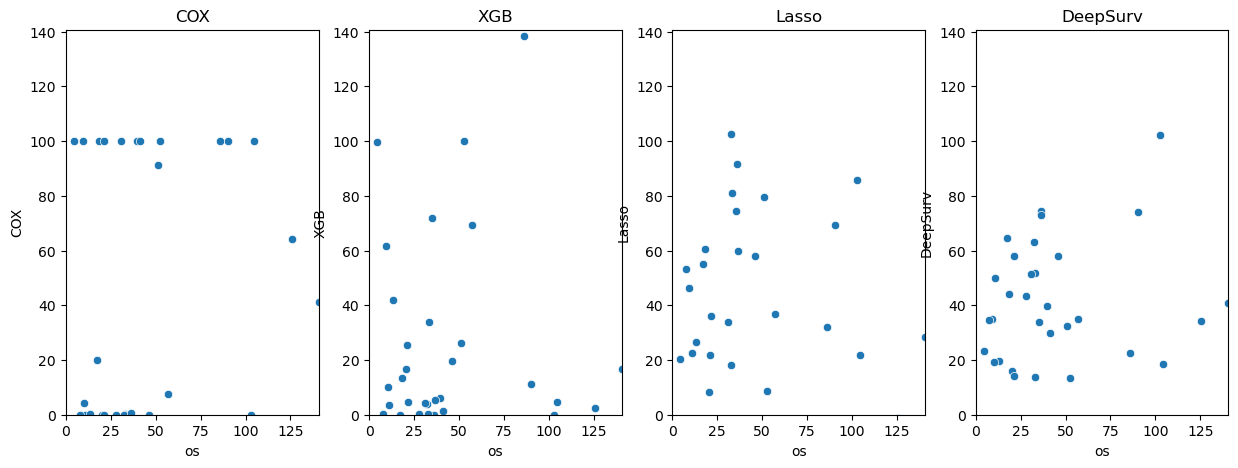

In [102]:
g,axs=plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    # g.add_subplot(1,4,i+1)
    # plt.plot(y_com['os'],y_com.iloc[:,2+i])
    ax=axs[i]
    sns.scatterplot(data=y_com,x='os',y=y_com.columns[2+i],ax=ax)
    upper_bound=max(max(y_com['os'].values),max(y_com[y_com.columns[2+i]].values))
    ax.set_title(y_com.columns[2+i])
    ax.set_xlim(0,upper_bound)
    ax.set_ylim(0,upper_bound)

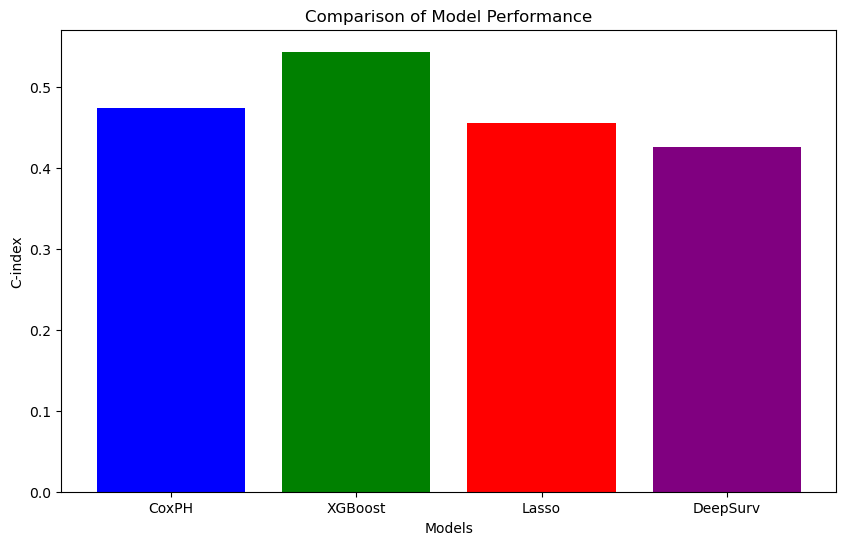

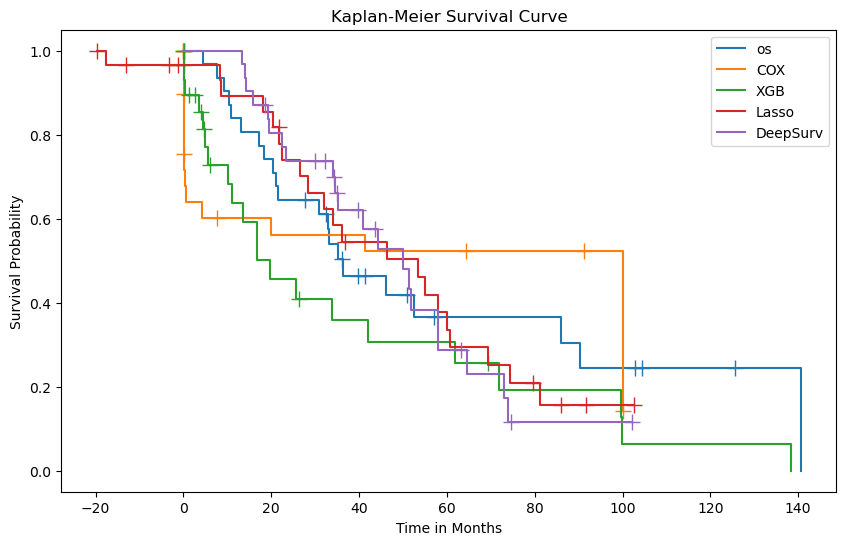

In [104]:

# Bar plot of C-index
models = ['CoxPH', 'XGBoost', 'Lasso', 'DeepSurv']
c_indices = [cox_cindex, xgb_cindex, lasso_cindex, deepsurv_cindex]

plt.figure(figsize=(10, 6))
plt.bar(models, c_indices, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('C-index')
plt.title('Comparison of Model Performance')
plt.show()

# Survival Curves (using CoxPH as example)


plt.figure(figsize=(10, 6))
model_names=['os','COX','XGB','Lasso','DeepSurv']
kmf = KaplanMeierFitter()
for i,col in enumerate(model_names):
    # if col=='COX':
    #     continue
    kmf.fit(y_com[col], event_observed=y_com['oss'])
    kmf.plot_survival_function(show_censors=True,ci_show=False,label=col)

plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time in Months')
plt.ylabel('Survival Probability')
plt.show()


<Axes: xlabel='timeline'>

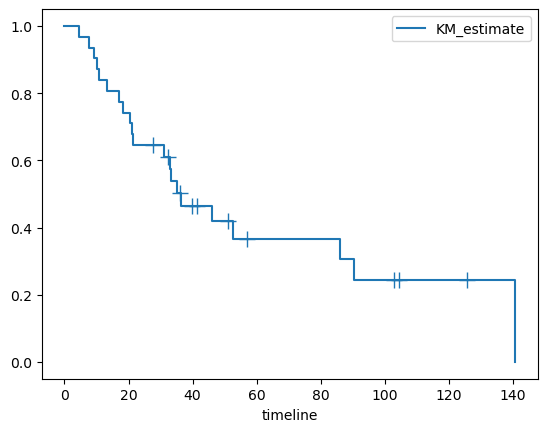

In [86]:

kmf = KaplanMeierFitter()
kmf.fit(y_test['os'], event_observed=y_test['oss'])
kmf.plot_survival_function(show_censors=True,ci_show=False)